In [1]:
import sys
sys.path.append("/home/alexander/Work/Repos/")
from batchflow.models.tf import DeepGalerkin
from batchflow import Pipeline, Dataset, DatasetIndex, Batch, B, L, F, V
from batchflow import NumpySampler as NS
import numpy as np
import matplotlib.pyplot as plt
import batchflow
from tqdm import tqdm_notebook
from ipywidgets import interact
from batchflow.batchflow.sampler import cart_prod

In [2]:
import tensorflow as tf

### Configuring `DeepGalerkin` model for solving PDE

$$
f(x, y, t): \quad \frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} - \frac{\partial^2 f}{\partial y^2} = Q_{well}(x, y),
$$
$$f(x, y, 0)=p_0,$$
$$f(0, x, t) = p_0 \quad f(x, 0, t) = p_0.
$$

* Training points are from uniform distribution on **[0, 1]**, as the equation is solved on that domain.

In [3]:
st = NS('u', dim=2) & NS('e', scale=1).truncate(high=5) # uniform over [0, 1] and exponential over [0, T]

* configuring the well

In [6]:
r_well = 0.1
center_well = np.array((0.5, None)).reshape((1, 2))
q_mult = 5

* setting up `config` for `DeepGalerkin`-model

In [18]:
layout = 'faRf+faRfaf+af'
initial_condition = 0

form_lhs = {'d1': (0, 0, 1),
            'd2': ((-1, 0, 0), (0, -1, 0), (0, 0, 0))}

Q_rhs = lambda t: 0.5 * q_mult * (tf.sign(r_well**2
                                          - tf.reduce_sum(tf.square((t[:, :1] - center_well[0, 0])),
                                                          axis=1, keepdims=True)) + 1)
T = 5
domain=[[0, 1], [0, 1], [0, T]]

config = {
    'inputs': dict(points={'shape': (3, )}),
    'initial_block/inputs': 'points',
    'body': dict(layout=layout,
                 units=[10, 10, 25, 30, 25, 1],
                 activation=[tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]),
    'common': dict(form=form_lhs,
                   bind_bc_ic=True,
                   initial_condition=initial_condition,
                   Q=Q_rhs,
                   domain=domain,
                   time_multiplier='sigmoid'),
    'loss': 'mse'}

Note:
* `f` in `layout=[fafaf]` stands for a **f**ully-connected layer
* `a` in `layout=[fafaf]` stands for **a**ctivation-function

So, coupled with `activation=[tf.nn.tanh, tf.nn.tanh]` and `units=[10, 15, 1]`, `layout='fafaf'` sets up a fully-connected network with 2 hidden layers (with 10 and 15 units) and `tanh`-activations.

Note also:
* `form={'d1':(0, 0, 1), 'd2':((-1, 0, 0), (0, -1, 0), (0, 0, 0)}` sets up the left-hand-side of the equation as $$\frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} - \frac{\partial^2 f}{\partial y^2}=\dots$$

* `Q_rhs = lambda t: 0.5 * q_mult * (tf.sign(r_well**2 - tf.square(t[:, :1] - center_well)) + 1)` says that the right-hand side of the equation is given by
$$\dots = q_{mult}  \mathcal{I}\left[x \in B_{0.1}(0.5)\right]$$
* `initial_condition = p_0` states that initial condition is given by
$$ f = p_0 $$

### Preparing training `pipeline` 

In [19]:
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(st.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

In [20]:
dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

### Running 3000-iters of network-training

In [21]:
dg = pipeline_ds.get_model_by_name('DG')

In [22]:
for i in tqdm_notebook(range(3000)):
    pipeline_ds.next_batch(400, n_epochs=None)

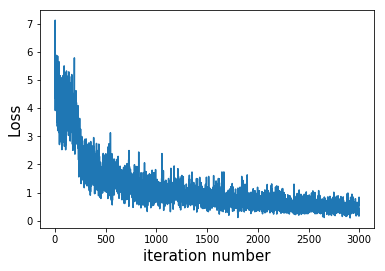

In [23]:
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
pass

### Plot the network solution

In [24]:
tsteps = np.linspace(0, 3, 1000)
n_el = 50
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))

approxs = [dg.session.run(dg.approximator, feed_dict={dg.points:
                                                      np.concatenate([grid, t * np.ones_like(grid[:, :1])],
                                                                     axis=1)}).reshape(n_el, n_el) for
          t in tsteps]

preds = [dg.session.run(dg.predictions, feed_dict={dg.points:
                                               np.concatenate([grid, t * np.ones_like(grid[:, :1])],
                                                               axis=1)}).reshape(n_el, n_el) for
          t in tsteps]

Text(0.5, 1.0, 'Parabolic PDE in $dim=2$')

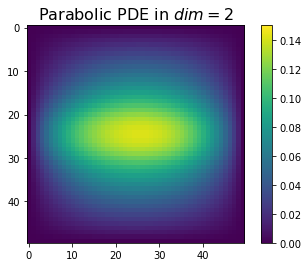

In [37]:
plt.imshow(approxs[700], vmin=0.0, vmax=0.15)
plt.colorbar()
plt.title('Parabolic PDE in $dim=2$', fontdict={'fontsize': 16})